In [7]:
import numpy as np
import pandas as pd

import emcee
import corner

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/(sig * np.sqrt(2) * np.pi)


# Plot Percentiles

In [2]:
CWD

'/home/ekaterina/Documents/001_science/MalachiteMountains'

In [5]:
res = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv", skiprows=11,)
res = res[res.index%2==0]


In [6]:
res = res.loc[[4,6,20,24,26,30],]
res

,date,ID,burnin,steps,walkers,nparam,t01_p16,t01_p50,t01_p84,theta_a_p16,...,radius_p16,radius_p50,radius_p84,ED_distr1_p16,ED_distr1_p50,ED_distr1_p84,Eflare1_p16,Eflare1_p50,Eflare1_p84,Unnamed: 33
4,11_02_2020_11_16,237880881a,50000,126742,32,10,1331.66400897832,1331.66405852341,1331.66408293647,13.5378094966208,...,46.8267524633738,53.5025151861576,74.6806472911025,6493.35337741692,9288.3462142352,13454.9483964226,5.76005196768358E+034,8.23940324484771E+034,1.19354665426703E+035,NaN
6,11_02_2020_11_16,237880881b,50000,126742,32,10,1331.82436563852,1331.82462120353,1331.82613215887,40.8909703163573,...,17.1097952600288,19.3717278583333,20.3491014571879,4349.44196217513,5487.60128869995,5992.37039293116,3.85825478398938E+034,4.86788054855767E+034,5.31564553269742E+034,NaN
20,06_03_2020_10_16,100004076,150000,590751,32,6,1358.51221233685,1358.51274040472,1358.51328990776,-14.5867123740818,...,15.8347733112126,20.5015978036307,32.9827966335637,30931.7893387612,46581.3536108787,114778.001837465,3.46292269637279E+033,5.21494650310258E+033,1.28498013242706E+034,NaN
24,11_02_2020_10_07,237880881a,34903,1576002,32,9,1331.66385326558,1331.66387122321,1331.66388820846,57.8795686074588,...,42.0206628759492,42.2100433396356,42.333080319898,4939.39368169012,4987.5330189568,5031.50265263991,4.38158261867168E+034,4.42428552859035E+034,4.46328962405442E+034,NaN
26,11_02_2020_10_07,237880881b,34903,1576002,32,9,1331.82639427697,1331.82654088914,1331.82668586329,57.8795686074588,...,16.7247046012945,16.7956777286697,16.8856247953146,4689.25209389904,4724.91710976565,4772.26816371612,4.15968979054276E+034,4.19132711764934E+034,4.23333076593805E+034,NaN
30,08_07_2020_11_48,277539431,1861,1013992,32,6,1641.8428495283,1641.84461193767,1641.8458447766,81.6016129258368,...,16.3701682013347,18.0028165265795,19.5463976578376,23679.2336289383,28430.4519399802,33267.9006130536,2.6671583118474E+034,3.20232138377259E+034,3.74719718671053E+034,NaN


In [ ]:
plt.figure(figsize=(8,5))
x = np.linspace(0,90,300)
for i, row in res.iterrows():
    a, up, lo = float(row.theta_a_p50), float(row.theta_a_p84), float(row.theta_a_p16)
    print(up-a,a-lo,row.ID,row.nparam)
    plt.plot(x, gaussian(x,a,(up-lo)/2), label=f"{row.ID} ({row.nparam})")
plt.legend(loc=2, frameon=False)
plt.xlim(0,90)
plt.xlabel(r"flare latitude $\theta$ [deg]")
plt.ylabel(r"probability")
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flare_latitudes.png",dpi=300)

In [13]:
props[props.ID == str(ID)]

,date,ID,burnin,steps,walkers,nparam,t01_p16,t01_p50,t01_p84,theta_a_p16,...,radius_p16,radius_p50,radius_p84,ED_distr1_p16,ED_distr1_p50,ED_distr1_p84,Eflare1_p16,Eflare1_p50,Eflare1_p84,Unnamed: 33
30,08_07_2020_11_48,277539431,1861,1013992,32,6,1641.8428495283,1641.84461193767,1641.8458447766,81.6016129258368,...,16.3701682013347,18.0028165265795,19.5463976578376,23679.2336289383,28430.4519399802,33267.9006130536,2.6671583118474E+034,3.20232138377259E+034,3.74719718671053E+034,NaN


# Plot Posteriors and Calculate physical properties

In [9]:
columns = ["t0_d","latitude_deg","a","fwhm_d","i_deg","phase_deg"]
#props = pd.read_csv(f"{CWD}/data/summary/everything.csv")
props = res
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")

In [15]:
# What dataset do you want to analyse?
suffix = ""

ID = 277539431#237880881#44984200#230120143##212035340 #230120143#
tstamp = "08_07_2020_11_48"#""11_02_2020_10_07"#20_02_2020_12_04"#'13_12_2019_10_18'#'27_01_2020_12_28'#

# Pick up the input parameters
target = props[props.ID == str(ID)].iloc[0]
inits = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

qlum = inits.qlum_erg_s * u.erg / u.s
Fth = inits.Fth * u.erg/ u.cm**2 / u.s
median = inits['median']
R = inits.R_Rsun * R_sun

# Pick up the LC
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

In [17]:
resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_converted_mcmc_sample.csv")



In [19]:
suffix = ""
from funcs.model import calculate_angular_radius, calculate_ED

percentiles = [16,50,84]

resultframe[f"rad_rsun{suffix}"] = resultframe.apply(lambda x: calculate_angular_radius(Fth, x[f"a{suffix}"], qlum, R), axis=1)

resultframe[f"ED_s{suffix}"] = resultframe.apply(lambda x: calculate_ED(lc.t.values, 
                                                                   x[f"t0_d{suffix}"], 
                                                                   x[f"fwhm_d{suffix}"], 
                                                                   x[f"a{suffix}"]),
                                           axis=1)

In [20]:
resultframe.to_csv(f"{CWD}/analysis/results/mcmc/{target.ID}_{tstamp}_converted_mcmc_sample.csv", index=False)

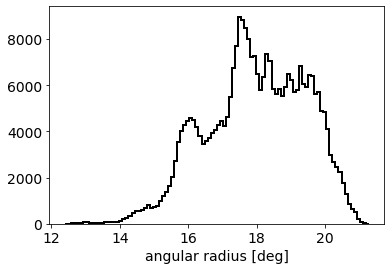

In [16]:
plt.hist(resultframe.rad_rsun.values,bins=100, histtype="step",color="k",linewidth=2);
plt.xlabel("angular radius [deg]")
radius_p = np.percentile(resultframe.rad_rsun.values, percentiles, axis=0)
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_active_region_radii.png",dpi=300)

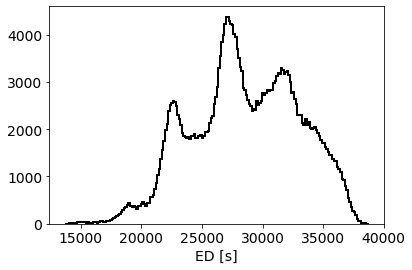

In [17]:
ED_distr = resultframe.ED_s.values
ED_distr_p = np.percentile(ED_distr, percentiles, axis=0)
plt.hist(ED_distr,bins=200, histtype="step",color="k",linewidth=2);
plt.xlabel("ED [s]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flare_ED.png",dpi=300)

In [ ]:
resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/{target.ID}_{tstamp}_converted_mcmc_sample.csv")

In [21]:
t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p = map(lambda v: (v[0], v[1], v[2]),
                                                   zip(*np.percentile(resultframe[["t0_d","latitude_deg","a","fwhm_d","i_deg","phase_deg"]].values,
                                                                      percentiles,
                                                       axis=0)))

with open(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv","a") as f:
    #Add more lines here
    
    out = f"{tstamp},{target.ID},"
    firstout = f"date,ID,"
    for i in ['t0_p', 'theta_a_p', 'a_p', 'fwhm_p', 'i_p', 'phi0_p', 'radius_p', 'ED_distr_p', 'Eflare_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p, radius_p, ED_distr_p, (ED_distr_p*qlum).value ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)

In [25]:
1.5e6/60/60/24

17.36111111111111

# Plot posterior

Index(['t0_d_a', 't0_d_b', 'latitude_deg', 'a_a', 'a_b', 'fwhm_d_a', 'fwhm_b',
       'i_deg', 'phase_deg', 'rad_rsun', 'ED_s', 'rad_rsun_a', 'ED_s_a'],
      dtype='object')


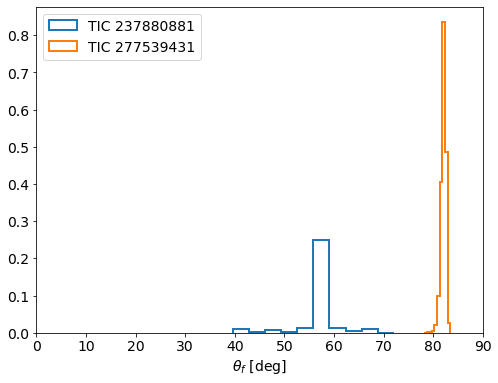

In [43]:


bins = 200
plt.figure(figsize=(8,6))

R = res.loc[[24,30]]

for index, row in R.iterrows():
    if row.ID[-1] in "ab":
        suffix = ""
        ID = row.ID[:-1]
        resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/{row.date}_{ID}_converted_mcmc_sample.csv")
        print(resultframe.columns)
    else:
        suffix = ""
        ID = row.ID
        resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/{row.date}_{ID}_converted_mcmc_sample.csv")
    plt.hist(resultframe[f"latitude_deg{suffix}"].values, 
             histtype="step", linewidth=2, density=True,
             label=f"TIC {ID}")
    
plt.xlim(0,90)
plt.xlabel(r"$\theta_f$ [deg]")
plt.legend()